In [1]:
import matplotlib.pyplot as plt
plt.ioff()

# Loading Data
from src.data_preparation import load_data

PROCESSED_DATA_PATH = "data/processed/df_1h_lag_BLV_spatial_images.csv"
df = load_data(PROCESSED_DATA_PATH, date_col="measurement_time")

df.drop(columns=["Unnamed: 0", "timestamp"], inplace=True)



df_interpolated = df.interpolate(method='linear')

df_interpolated.fillna(0, inplace=True)

features_to_check = ['ghi', 'dni', 'solar_zenith', 'GHI_cs', 'DNI_cs', 'CSI_ghi', 
                                   'CSI_dni',
                                   'nam_ghi', 'nam_dni', 'nam_cc', 'B_CSI_ghi_8h', 'V_CSI_ghi_8h', 'L_CSI_ghi_8h', 'B_CSI_ghi_9h',
       'V_CSI_ghi_9h', 'L_CSI_ghi_9h', 'B_CSI_ghi_10h', 'V_CSI_ghi_10h',
       'L_CSI_ghi_10h', 'B_CSI_ghi_11h', 'V_CSI_ghi_11h', 'L_CSI_ghi_11h',
       'B_CSI_ghi_12h', 'V_CSI_ghi_12h', 'L_CSI_ghi_12h', 'B_CSI_ghi_13h',
       'V_CSI_ghi_13h', 'L_CSI_ghi_13h', 'B_CSI_ghi_14h', 'V_CSI_ghi_14h',
       'L_CSI_ghi_14h', 'B_CSI_ghi_15h', 'V_CSI_ghi_15h', 'L_CSI_ghi_15h',
       'B_CSI_ghi_16h', 'V_CSI_ghi_16h', 'L_CSI_ghi_16h', 'B_CSI_ghi_17h',
       'V_CSI_ghi_17h', 'L_CSI_ghi_17h', 'B_CSI_ghi_18h', 'V_CSI_ghi_18h',
       'L_CSI_ghi_18h', 'B_CSI_ghi_19h', 'V_CSI_ghi_19h', 'L_CSI_ghi_19h',
       '80_dwsw', '80_cloud_cover', '56_dwsw', '56_cloud_cover',
       '20_dwsw', '20_cloud_cover', '88_dwsw', '88_cloud_cover', 'AVG(R)',
       'STD(R)', 'ENT(R)', 'AVG(G)', 'STD(G)', 'ENT(G)', 'AVG(B)', 'STD(B)',
       'ENT(B)', 'AVG(RB)', 'STD(RB)', 'ENT(RB)', 'AVG(NRB)', 'STD(NRB)',
       'ENT(NRB)']

# 2. Calculate the number of NaN values for each feature
# We use .isna() instead of == 0
nans_per_feature = df_interpolated[features_to_check].isna().sum()

# 3. Filter to get only features that actually have NaN values
features_with_nans = nans_per_feature[nans_per_feature > 0]

# 4. Report the findings for which features have NaNs
if features_with_nans.empty:
    print("No NaN (missing) values found in any of the specified features.")
else:
    print("--- Features With NaN Values ---")
    print("The following features have NaN values, with the total count for each:")
    # Sort for clearer output
    print(features_with_nans.sort_values(ascending=False))
    print("\n" + "="*40 + "\n")

    # 5. Analyze the distribution of hours for rows containing NaNs
    print("--- Distribution of NaN-Value Records by Hour ---")
    
    # Create a boolean mask for rows that contain *at least one* NaN
    # in the specified columns
    rows_with_any_nan = df_interpolated[features_to_check].isna().any(axis=1)
    
    if rows_with_any_nan.sum() > 0:
        # Get the index for these rows
        nan_rows_index = df_interpolated.index[rows_with_any_nan]
        
        # Extract the hour from the DatetimeIndex and get the value counts
        hour_distribution = nan_rows_index.hour.value_counts().sort_index()
        
        print("Distribution of records (rows) containing at least one NaN, by hour:")
        print(hour_distribution)
        
        # Optional: Print total number of affected rows
        print(f"\nTotal number of rows with at least one NaN: {rows_with_any_nan.sum()}")
    else:
        # This case shouldn't be hit if features_with_nans was not empty,
        # but it's good practice to include.
        print("No rows found with NaN values (this is unexpected, check logic).")


import torch
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if hasattr(torch.backends, "mps") and torch.backends.mps.is_available()
    else "cpu"
)

device

df_phase1 = df_interpolated[['CSI_ghi','time_gap_hours',
       'time_gap_norm',
       'season_flag', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos']]

Loaded 11,560 records
Date range: 2014-01-03 14:00:00+00:00 to 2016-12-30 23:00:00+00:00
Timezone: UTC
No NaN (missing) values found in any of the specified features.


/tmp/ipykernel_694223/1715085752.py:14: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_interpolated = df.interpolate(method='linear')


In [2]:
from src.preprocessing import build_model_arrays, to_fixedgrid_multiindex
import pandas as pd
from src.utils import DataManager
from src.pipeline import SolarForecastingPipeline

# --- Block 1: Define variables ---

TARGET_COL = "CSI_ghi"  # <-- FIX 1: Define Target FIRST
history_days = 7
horizon_days = 1

# This list now correctly excludes the target
feature_cols = [c for c in df_phase1.columns.tolist() if c != TARGET_COL]
#
# --- Block 2: Build model arrays (Your code was correct here) ---


print("\n--- Step 2: Building model arrays (X, Y) ---")
fixed_df = to_fixedgrid_multiindex(df_phase1, timestamp_col="measurement_time", expected_T=None)  # or set T
fixed_df.shape


--- Step 2: Building model arrays (X, Y) ---


(11560, 8)

In [3]:
# X: A 4D tensor of shape (samples, history_days, K:hours/Bins, F:features)

ph1_X, ph1_Y, ph1_labels_list = build_model_arrays(
        fixed_df,
        feature_cols=feature_cols,  
        target_col=TARGET_COL,
        history_days=history_days,
        horizon_days=horizon_days,
    )

ph1_X.shape, ph1_Y.shape, len(ph1_labels_list)

((1055, 7, 11, 7), (1055, 1, 11), 1055)

In [4]:
# --- Block 3: Save arrays ---
data_manager = DataManager()
data_manager.save_arrays(
    ph1_X, ph1_Y,
    pd.DataFrame(index=pd.to_datetime(ph1_labels_list, utc=True)),
    filename_prefix='phas1_data',  # <-- You are saving as 'phas2_data'
    feature_cols=feature_cols,
    target_col=TARGET_COL,
    metadata={
        "input_csv": "data/processed/df_1h_lag_BLV_spatial_images.csv",
        "timestamp_col": "measurement_time",
        "feature_set": feature_cols,
        "history_days": 7,
        "horizon_days": 1,
    }
)

INFO:src.utils:Saved arrays to data/phas1_data_*.npy
INFO:src.utils:X shape: (1055, 7, 11, 7), Y shape: (1055, 1, 11)


In [5]:
# --- Block 4: Configure and Run ---
LSTM_CONFIG = {
    "experiment_name": "BiLSTM_p1_exp01_essentialF",
    "model_type": "LSTM",
    "model_config": {
        "hidden_size": 64,
        "num_layers": 2,
        "dropout": 0.35,
        "bidirectional": True,
        "use_attention": False,
        # "steps_per_day": 11,
        "activation_function": "ReLU"

    },
    "data_prefix": "phas1_data",  # <-- FIX 2: Match the filename_prefix
    "splits_file": "exp-004/exp-004rolling_origin_splits.json",
    "feature_cols": feature_cols,
    "feature_selection": feature_cols, # <-- This is correct!
    "target_col": TARGET_COL,
    "batch_size": 32,
    "num_epochs": 50,
    "learning_rate": 0.001,
    "loss_function": "Huber", 
    "early_stopping_patience": 20,
    "max_folds": 35,
    "scale_target": False,
}

pipeline = SolarForecastingPipeline(LSTM_CONFIG)
LSTM_CONFIG.update({
    "truth_csi_col": "actual_csi",
    "truth_ghi_col": None,     # or None to reconstruct as CSI * clear_sky_ghi
    "ghi_cs_col":    "clear_sky_ghi",
    "nam_ghi_col":   "nam_ghi",
    "nam_csi_col":   None,        # optional; benchmark will derive if missing
})

In [6]:
pipeline = SolarForecastingPipeline(LSTM_CONFIG)

-----

### Run Function ,and model evaluation

### Step 01

In [7]:
# Step 2: Run....
# Save configuration to json file. 
# After this step TEST_UniLSTM_test_data_{dat_time} dire for the exp will be created
# config.json 
pipeline.tracker.save_config(pipeline.config)


In [8]:
import logging
# Setup logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
# Load data
logger.info("Loading data...")
X, Y, labels, metadata = pipeline.data_manager.load_arrays(
            filename_prefix=pipeline.config.get('data_prefix', 'kbins_data')
)

INFO:__main__:Loading data...
INFO:src.utils:Loaded arrays from data/phas1_data_*.npy
INFO:src.utils:X shape: (1055, 7, 11, 7), Y shape: (1055, 1, 11)


In [9]:
saved_features = metadata.get("feature_cols")
expected_features = pipeline.config.get("feature_cols")
if expected_features is not None:
    if saved_features is not None and list(expected_features) != list(saved_features):
        raise ValueError(
                    "Feature mismatch between configuration and saved arrays. "
                    f"Config expects {expected_features}, arrays contain {saved_features}."
                )
else:
    pipeline.config["feature_cols"] = saved_features

pipeline.config["feature_cols"]

['time_gap_hours',
 'time_gap_norm',
 'season_flag',
 'hour_sin',
 'hour_cos',
 'month_sin',
 'month_cos']

In [10]:
labels_index = labels.index if labels is not None else None
c = 0
for i in labels_index:
    print(i)
    c+=1
    if c == 10:
        break
    

2014-01-10 00:00:00+00:00
2014-01-11 00:00:00+00:00
2014-01-12 00:00:00+00:00
2014-01-13 00:00:00+00:00
2014-01-14 00:00:00+00:00
2014-01-15 00:00:00+00:00
2014-01-16 00:00:00+00:00
2014-01-17 00:00:00+00:00
2014-01-18 00:00:00+00:00
2014-01-19 00:00:00+00:00


In [11]:
from src.evaluation_utils import _load_processed_dataframe
csv_path = metadata.get("input_csv", PROCESSED_DATA_PATH) 
# ALL The data are existed here.
base_df = _load_processed_dataframe(csv_path) 

from src.evaluation_utils import build_reference_from_existing
logger.info("Building simple reference from existing columns (no pvlib, no regridding)...")

pipeline.reference_df = build_reference_from_existing(
                    base_df,                         # <--  processed/merged modeling df
                    time_col="measurement_time",
                    nam_time_col="nam_target_time",
                    meas_ghi_col="ghi",
                    nam_ghi_col="nam_ghi",
                    cs_ghi_col="GHI_cs",
                    actual_csi_col="CSI_ghi",
                )

INFO:__main__:Building simple reference from existing columns (no pvlib, no regridding)...
/home/muhammadhassan/App_v02/src/evaluation_utils.py:132: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  ref["nam_csi"].replace([np.inf, -np.inf], np.nan, inplace=True)


In [12]:
pipeline.reference_df

,actual_ghi,nam_ghi,clear_sky_ghi,actual_csi,nam_csi
target_time,,,,,
2014-01-03 15:00:00+00:00,0.000000,0.000,0.000000,0.000000,0.000000
2014-01-03 16:00:00+00:00,12.914500,99.625,0.000000,1.200000,0.000000
2014-01-03 17:00:00+00:00,143.775500,274.750,35.159500,1.200000,7.814389
2014-01-03 18:00:00+00:00,289.955000,416.375,184.554711,1.200000,2.256106
2014-01-03 19:00:00+00:00,402.643333,510.875,321.992462,1.200000,1.586605
...,...,...,...,...,...
2016-12-30 20:00:00+00:00,433.891667,481.125,412.514321,1.051822,1.166323
2016-12-30 21:00:00+00:00,449.525000,453.875,448.963991,1.001250,1.010939
2016-12-30 22:00:00+00:00,410.876667,370.250,427.167267,0.961864,0.866756


In [13]:
logger.info("Reference dataframe prepared (%d rows).", len(pipeline.reference_df))

INFO:__main__:Reference dataframe prepared (11560 rows).


In [14]:
# Load splits
splits_data = pipeline.data_manager.load_rolling_splits(
            pipeline.config.get('splits_file', 'rolling_origin_splits.json')
        )

INFO:src.utils:Loaded 35 folds from exp-004/exp-004rolling_origin_splits.json


In [15]:
# Run each fold
fold_results = []
max_folds = pipeline.config.get('max_folds', len(splits_data['folds']))


In [16]:
fold_0_data = splits_data['folds'][5]
fold_id = fold_0_data['fold_id']
fold_id

6

In [17]:
if labels is not None:
    train_idx, val_idx = pipeline.data_manager.get_fold_indices(
                    X, labels, fold_0_data
                )

### Deep Look in run_fold()
My Issues Here ...

Signature 

```python 

 def run_fold(self, X: np.ndarray, Y: np.ndarray,
                 train_idx: np.ndarray, val_idx: np.ndarray,
                 fold_id: int,
                 labels_index: Optional[pd.Index] = None,
                 reference_df: Optional[pd.DataFrame] = None) -> Dict:
```
```python
# Run fold Function
            fold_result = self.run_fold(
                X,
                Y,
                train_idx,
                val_idx,
                fold_id,
                labels_index=labels_index,
                reference_df=self.reference_df,
            )
            fold_results.append(fold_result)
```

In [18]:
logger.info(f"\n=== Running Fold {fold_id} ===")
logger.info(f"Train samples: {len(train_idx)}, Val samples: {len(val_idx)}")

INFO:__main__:
=== Running Fold 6 ===
INFO:__main__:Train samples: 162, Val samples: 29


In [19]:
X_train, Y_train = X[train_idx], Y[train_idx]
X_val, Y_val = X[val_idx], Y[val_idx]

In [20]:
print(X_train.shape)

N, H, T, F = X_train.shape
flat = X.reshape(-1, F)

flat.shape

(162, 7, 11, 7)


(81235, 7)

In [21]:
# --- Feature scaling (fit on TRAIN only) ---
from src.utils import fit_feature_scaler, transform_X_with_scaler, fit_target_scaler, transform_Y_with_scaler
# --- Feature scaling (fit on TRAIN only) ---
feature_scaler = fit_feature_scaler(X_train)

X_train = transform_X_with_scaler(X_train, feature_scaler)
X_val   = transform_X_with_scaler(X_val,   feature_scaler)

In [22]:
# Test Scaling performence
target_scaler = None
if pipeline.config.get("scale_target", False):
    target_scaler = fit_target_scaler(Y_train)
    Y_train = transform_Y_with_scaler(Y_train, target_scaler)
    Y_val   = transform_Y_with_scaler(Y_val,   target_scaler)

In [23]:
logger.info(f"X_train scaled range: [{X_train.min():.3f}, {X_train.max():.3f}]")
logger.info(f"Y_train scaled range: [{Y_train.min():.3f}, {Y_train.max():.3f}]")

pipeline.scaler_info = {
            "feature_scaler": feature_scaler,
            "target_scaler": target_scaler,
        }
pipeline.scaler_info

INFO:__main__:X_train scaled range: [-1.000, 1.000]
INFO:__main__:Y_train scaled range: [0.000, 1.200]


{'feature_scaler': MinMaxScaler(feature_range=(-1, 1)), 'target_scaler': None}

In [24]:
X_train.shape

(162, 7, 11, 7)

In [25]:
import torch
from torch.utils.data import TensorDataset, DataLoader

train_ds = TensorDataset(
            torch.from_numpy(X_train).float(),
            torch.from_numpy(Y_train).float()
        )
val_ds = TensorDataset(
            torch.from_numpy(X_val).float(),
            torch.from_numpy(Y_val).float()
        )

# shuffle=True Shuffling must be experienced.
train_loader = DataLoader(train_ds, batch_size=pipeline.config["batch_size"], shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=pipeline.config["batch_size"], shuffle=False)


In [26]:
# Create model
input_size   = X.shape[-1]    # features
steps_per_day = X.shape[2]    # grid steps per day (e.g., 24, 48)
horizon_days = Y.shape[1]

print(input_size, steps_per_day, horizon_days)
model = pipeline.create_model(
    pipeline.config['model_type'],
    input_size,
    horizon_days,
    steps_per_day=steps_per_day, 
)

model

7 11 1


ImprovedLSTM(
  (input_projection): Linear(in_features=77, out_features=64, bias=True)
  (lstm): LSTM(64, 64, num_layers=2, batch_first=True, dropout=0.35, bidirectional=True)
  (dropout): Dropout(p=0.35, inplace=False)
  (activation): ReLU()
  (output_projection): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.35, inplace=False)
    (3): Linear(in_features=64, out_features=11, bias=True)
  )
)

##### ReLU is used, does this affect the Memorization problem so we have to use Tanh?


In [27]:
logger.info(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
loss_function_name = pipeline.config.get('loss_function', 'MSE')
loss_function_name

INFO:__main__:Model parameters: 179,851


'Huber'

### Painful Important Part 

```python

history = train_model(
            model,
            train_loader,
            val_loader,
            num_epochs=self.config.get('num_epochs', 100),
            learning_rate=self.config.get('learning_rate', 0.001),
            device=self.device,
            loss_function=loss_function_name,
            early_stopping_patience=self.config.get('early_stopping_patience', 20)
        )

```

```python

def train_model(model: nn.Module, 
                train_loader: DataLoader, 
                val_loader: DataLoader,
                num_epochs: int = 100, 
                learning_rate: float = 0.001,       
                loss_function:str = "MSE",
                device: str = 'cpu', 
                early_stopping_patience: int = 20) -> Dict:
```

In [28]:
num_epochs=pipeline.config.get('num_epochs', 100)
learning_rate=pipeline.config.get('learning_rate', 0.001)
device=pipeline.device
loss_function=loss_function_name
early_stopping_patience=pipeline.config.get('early_stopping_patience', 20)

In [29]:
import torch.nn as nn

device = torch.device(device)
model = model.to(device)

if loss_function.lower() == 'huber':
    criterion = nn.HuberLoss(delta=1.0)
    logger.info("Using HuberLoss (Smooth L1 Loss)")

INFO:__main__:Using HuberLoss (Smooth L1 Loss)


In [30]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# learning rate scheduler. Its job is to change the learning rate during training, based on the model's performance.
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=10
    )

In [31]:
history = {
        'train_loss': [],
        'val_loss': [],
        'train_mae': [],
        'val_mae': [],
        'lr': []
    }

In [32]:
best_val_loss = float('inf')
patience_counter = 0
best_model_state = None

In [33]:
from src.engine import _extract_xy, _move_to_device
import torch.nn.functional as F 

model.train()
train_loss = 0.0
train_mae = 0.0
train_batches = 0

for batch in train_loader:
    Xb, Yb = _extract_xy(batch)
    Xb, Yb = _move_to_device(Xb, device), _move_to_device(Yb, device)

    optimizer.zero_grad()
    outputs = model(Xb)
    loss = criterion(outputs, Yb)

    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()

    train_loss += loss.item()
    # safer & faster than sklearn per-batch
    train_mae  += F.l1_loss(outputs, Yb).item()
    train_batches += 1

In [34]:
from src.engine import train_model, evaluate_model
history = train_model(
            model,
            train_loader,
            val_loader,
            num_epochs=pipeline.config.get('num_epochs', 100),
            learning_rate=pipeline.config.get('learning_rate', 0.001),
            device=pipeline.device,
            loss_function=loss_function_name,
            early_stopping_patience=pipeline.config.get('early_stopping_patience', 20)
        )

INFO:src.engine:Using HuberLoss (Smooth L1 Loss)
INFO:src.engine:Epoch [10/50] - Train Loss: 0.073170, Val Loss: 0.013540, Train MAE: 0.309064, Val MAE: 0.105889, LR: 0.001000
INFO:src.engine:Epoch [20/50] - Train Loss: 0.053956, Val Loss: 0.014340, Train MAE: 0.264439, Val MAE: 0.098653, LR: 0.001000
INFO:src.engine:Epoch [30/50] - Train Loss: 0.047883, Val Loss: 0.015237, Train MAE: 0.238394, Val MAE: 0.100386, LR: 0.001000
INFO:src.engine:Epoch [40/50] - Train Loss: 0.047195, Val Loss: 0.022415, Train MAE: 0.242636, Val MAE: 0.152379, LR: 0.001000
INFO:src.engine:Epoch [50/50] - Train Loss: 0.050448, Val Loss: 0.012189, Train MAE: 0.244707, Val MAE: 0.104938, LR: 0.000500


In [35]:
scaler_info = {
            'feature_scaler': feature_scaler,
            'target_scaler': target_scaler
        }
scaler_info

{'feature_scaler': MinMaxScaler(feature_range=(-1, 1)), 'target_scaler': None}

### Model Evaluation

In [36]:
device = torch.device(device) if not isinstance(device, torch.device) else device
model.eval()

ImprovedLSTM(
  (input_projection): Linear(in_features=77, out_features=64, bias=True)
  (lstm): LSTM(64, 64, num_layers=2, batch_first=True, dropout=0.35, bidirectional=True)
  (dropout): Dropout(p=0.35, inplace=False)
  (activation): ReLU()
  (output_projection): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.35, inplace=False)
    (3): Linear(in_features=64, out_features=11, bias=True)
  )
)

In [37]:
y_true_all, y_pred_all = [], []
import numpy as np
from src.engine import _extract_xy, _move_to_device, _compute_metrics
with torch.no_grad():
    for batch in val_loader:
        Xb, Yb = _extract_xy(batch)                # <— use helper
        Xb, Yb = _move_to_device(Xb, device), _move_to_device(Yb, device)
        Pb = model(Xb)
        y_true_all.append(Yb.detach().cpu().numpy())
        y_pred_all.append(Pb.detach().cpu().numpy())
    y_true = np.concatenate(y_true_all, axis=0)
    y_pred = np.concatenate(y_pred_all, axis=0)


In [38]:
ts = scaler_info 
print(ts)

metrics = _compute_metrics(y_true, y_pred)
out= {"metrics": metrics, "y_true": y_true, "y_pred": y_pred}
val_metrics, val_pred, val_true = out["metrics"], out["y_pred"], out["y_true"]

for k in ("MAPE", "sMAPE", "sMAPE_%", "per_horizon_MAPE"):
    val_metrics.pop(k, None)

{'feature_scaler': MinMaxScaler(feature_range=(-1, 1)), 'target_scaler': None}


In [39]:
pipeline.tracker.plot_training_history(history, fold=fold_id)
pipeline.tracker.save_predictions_plot(val_true, val_pred, fold=fold_id, split='validation')

pipeline.tracker.save_model(model, fold=fold_id, is_best=True)
pipeline.tracker.save_training_history(history, fold=fold_id)
pipeline.tracker.save_metrics(val_metrics, fold=fold_id, split='validation')

In [40]:
val_metrics, val_pred, val_true = evaluate_model(
            model,
            val_loader,
            device=pipeline.device,
            scaler_info=ts,
        )

In [41]:
val_metrics

{'MAE': 0.10493763536214828,
 'RMSE': 0.15613245964050293,
 'MAPE': 0.1694498509168625,
 'per_horizon_MAE': array([0.10493764], dtype=float32)}

### Plotting Functionalities


```python

plot_training_history(self, history: Dict, fold: int = 0)

```

History is a dictionary 


```python

history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['train_mae'].append(avg_train_mae)
        history['val_mae'].append(avg_val_mae)
        history['lr'].append(current_lr)
```

In [59]:
len(history['train_loss'])

50

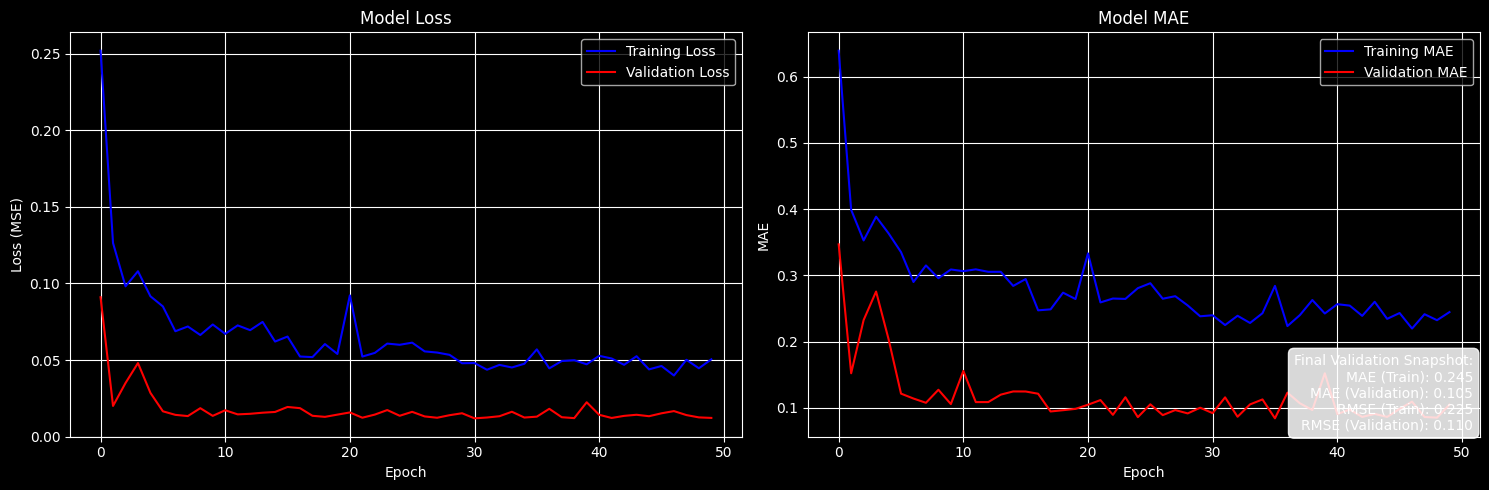

In [ ]:
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple, Optional, Any


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(history['train_loss'], label='Training Loss', color='blue')
ax1.plot(history['val_loss'], label='Validation Loss', color='red')
ax1.set_title('Model Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.legend()
ax1.grid(True)

ax2.plot(history['train_mae'], label='Training MAE', color='blue')
ax2.plot(history['val_mae'], label='Validation MAE', color='red')
ax2.set_title('Model MAE')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('MAE')
ax2.legend()
ax2.grid(True)

def _last(values: List[float]) -> Optional[float]:
        return float(values[-1]) if values else None

train_rmse = None
val_rmse = None

if 'train_loss' in history and history['train_loss']:
    train_rmse = float(np.sqrt(history['train_loss'][-1]))
    
if 'val_loss' in history and history['val_loss']:
    val_rmse = float(np.sqrt(history['val_loss'][-1]))

train_mae = _last(history.get('train_mae', []))
val_mae = _last(history.get('val_mae', []))

summary_lines = [
            "Final Validation Snapshot:",
            f"MAE (Train): {train_mae:.3f}" if train_mae is not None else "MAE (Train): n/a",
            f"MAE (Validation): {val_mae:.3f}" if val_mae is not None else "MAE (Validation): n/a",
            f"RMSE (Train): {train_rmse:.3f}" if train_rmse is not None else "RMSE (Train): n/a",
            f"RMSE (Validation): {val_rmse:.3f}" if val_rmse is not None else "RMSE (Validation): n/a",
        ]

ax2.text(
            0.99,
            0.01,
            "\n".join(summary_lines),
            transform=ax2.transAxes,
            fontsize=10,
            va="bottom",
            ha="right",
            bbox=dict(boxstyle="round,pad=0.4", facecolor="white", alpha=0.85),
        )
plt.tight_layout()
plt.show()

```python

self.tracker.save_predictions_plot(
        val_true, 
        val_pred, 
        fold=fold_id,   
        split='validation')

```

In [64]:
y_true.shape

(29, 1, 11)

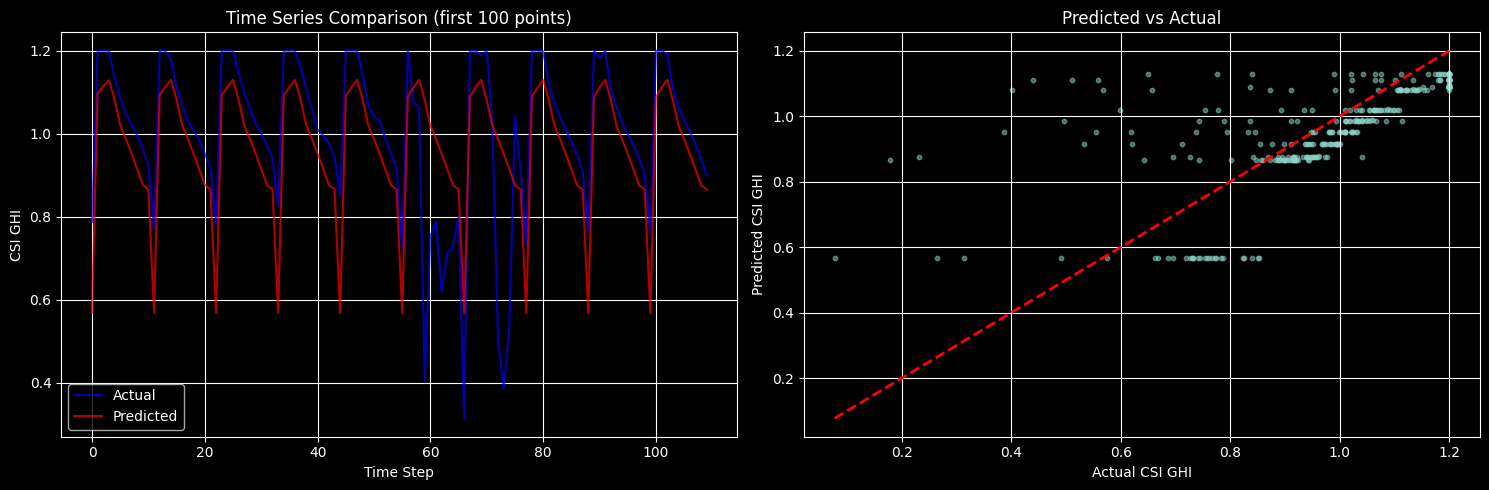

In [67]:
sample_size = 500
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Flatten if needed
y_true_flat = y_true.flatten()
y_pred_flat = y_pred.flatten()

# Sample if too large
if len(y_true_flat) > sample_size:
    idx = np.random.choice(len(y_true_flat), sample_size, replace=False)
    y_true_plot = y_true_flat[idx]
    y_pred_plot = y_pred_flat[idx]
else:
    y_true_plot = y_true_flat
    y_pred_plot = y_pred_flat

# Time series plot
ax1.plot(y_true_plot[:110], label='Actual', color='blue', alpha=0.7)
ax1.plot(y_pred_plot[:110], label='Predicted', color='red', alpha=0.7)
ax1.set_title(f'Time Series Comparison (first 100 points)')
ax1.set_xlabel('Time Step')
ax1.set_ylabel('CSI GHI')
ax1.legend()
ax1.grid(True)

# Scatter plot
ax2.scatter(y_true_plot, y_pred_plot, alpha=0.5, s=10)
ax2.plot([y_true_plot.min(), y_true_plot.max()], 
    [y_true_plot.min(), y_true_plot.max()], 
    'r--', lw=2)
ax2.set_title(f'Predicted vs Actual')
ax2.set_xlabel('Actual CSI GHI')
ax2.set_ylabel('Predicted CSI GHI')
ax2.grid(True)

plt.tight_layout()
plt.show()

---

### Benchmarking 


In [69]:
y_true_csi = np.asarray(val_true, dtype=float).reshape(-1)
y_pred_csi = np.asarray(val_pred, dtype=float).reshape(-1)

In [73]:
int(X.shape[2])

11

In [74]:
spd = pipeline.config.get("model_config", {}).get("steps_per_day")
if spd is None:
    spd = int(X.shape[2])  # (N, history_days, steps_per_day, features)

spd

11

In [75]:
# 3) Build label_times of length N_val * spd
#   Take validation *days* (one per sample) and expand by canonical intraday times
val_days = pd.to_datetime(labels_index[val_idx], utc=True).normalize()
val_days

DatetimeIndex(['2014-07-02 00:00:00+00:00', '2014-07-03 00:00:00+00:00',
               '2014-07-04 00:00:00+00:00', '2014-07-05 00:00:00+00:00',
               '2014-07-06 00:00:00+00:00', '2014-07-07 00:00:00+00:00',
               '2014-07-08 00:00:00+00:00', '2014-07-09 00:00:00+00:00',
               '2014-07-10 00:00:00+00:00', '2014-07-11 00:00:00+00:00',
               '2014-07-12 00:00:00+00:00', '2014-07-13 00:00:00+00:00',
               '2014-07-14 00:00:00+00:00', '2014-07-15 00:00:00+00:00',
               '2014-07-16 00:00:00+00:00', '2014-07-17 00:00:00+00:00',
               '2014-07-18 00:00:00+00:00', '2014-07-19 00:00:00+00:00',
               '2014-07-20 00:00:00+00:00', '2014-07-21 00:00:00+00:00',
               '2014-07-22 00:00:00+00:00', '2014-07-23 00:00:00+00:00',
               '2014-07-24 00:00:00+00:00', '2014-07-25 00:00:00+00:00',
               '2014-07-26 00:00:00+00:00', '2014-07-27 00:00:00+00:00',
               '2014-07-28 00:00:00+00:00', '2014-0

In [76]:
ref_idx = pipeline.reference_df.index
ref_idx

DatetimeIndex(['2014-01-03 15:00:00+00:00', '2014-01-03 16:00:00+00:00',
               '2014-01-03 17:00:00+00:00', '2014-01-03 18:00:00+00:00',
               '2014-01-03 19:00:00+00:00', '2014-01-03 20:00:00+00:00',
               '2014-01-03 21:00:00+00:00', '2014-01-03 22:00:00+00:00',
               '2014-01-03 23:00:00+00:00', '2014-01-04 00:00:00+00:00',
               ...
               '2016-12-30 15:00:00+00:00', '2016-12-30 16:00:00+00:00',
               '2016-12-30 17:00:00+00:00', '2016-12-30 18:00:00+00:00',
               '2016-12-30 19:00:00+00:00', '2016-12-30 20:00:00+00:00',
               '2016-12-30 21:00:00+00:00', '2016-12-30 22:00:00+00:00',
               '2016-12-30 23:00:00+00:00', '2016-12-31 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='target_time', length=11560, freq=None)

In [ ]:
tod_counts = pd.Series(ref_idx.time).value_counts()
top_times_sorted = sorted(list(tod_counts.index[:spd]))

In [81]:
label_times_list = []
for d in val_days:
    d_date = d.date()  # python date
    for t in top_times_sorted:
        ts_naive = pd.Timestamp.combine(d_date, t)
        ts = pd.Timestamp(ts_naive).tz_localize("UTC")
        label_times_list.append(ts)
label_times = pd.DatetimeIndex(label_times_list)

label_times

DatetimeIndex(['2014-07-02 00:00:00+00:00', '2014-07-02 03:00:00+00:00',
               '2014-07-02 15:00:00+00:00', '2014-07-02 16:00:00+00:00',
               '2014-07-02 17:00:00+00:00', '2014-07-02 18:00:00+00:00',
               '2014-07-02 19:00:00+00:00', '2014-07-02 20:00:00+00:00',
               '2014-07-02 21:00:00+00:00', '2014-07-02 22:00:00+00:00',
               ...
               '2014-07-30 03:00:00+00:00', '2014-07-30 15:00:00+00:00',
               '2014-07-30 16:00:00+00:00', '2014-07-30 17:00:00+00:00',
               '2014-07-30 18:00:00+00:00', '2014-07-30 19:00:00+00:00',
               '2014-07-30 20:00:00+00:00', '2014-07-30 21:00:00+00:00',
               '2014-07-30 22:00:00+00:00', '2014-07-30 23:00:00+00:00'],
              dtype='datetime64[ns, UTC]', length=319, freq=None)

----

In [82]:
import matplotlib.pyplot as plt
plt.ioff()

# Loading Data
from src.data_preparation import load_data

PROCESSED_DATA_PATH = "data/processed/df_1h_lag_BLV_spatial_images.csv"
df = load_data(PROCESSED_DATA_PATH, date_col="measurement_time")

df.drop(columns=["Unnamed: 0", "timestamp"], inplace=True)



df_interpolated = df.interpolate(method='linear')

df_interpolated.fillna(0, inplace=True)

features_to_check = ['ghi', 'dni', 'solar_zenith', 'GHI_cs', 'DNI_cs', 'CSI_ghi', 
                                   'CSI_dni',
                                   'nam_ghi', 'nam_dni', 'nam_cc', 'B_CSI_ghi_8h', 'V_CSI_ghi_8h', 'L_CSI_ghi_8h', 'B_CSI_ghi_9h',
       'V_CSI_ghi_9h', 'L_CSI_ghi_9h', 'B_CSI_ghi_10h', 'V_CSI_ghi_10h',
       'L_CSI_ghi_10h', 'B_CSI_ghi_11h', 'V_CSI_ghi_11h', 'L_CSI_ghi_11h',
       'B_CSI_ghi_12h', 'V_CSI_ghi_12h', 'L_CSI_ghi_12h', 'B_CSI_ghi_13h',
       'V_CSI_ghi_13h', 'L_CSI_ghi_13h', 'B_CSI_ghi_14h', 'V_CSI_ghi_14h',
       'L_CSI_ghi_14h', 'B_CSI_ghi_15h', 'V_CSI_ghi_15h', 'L_CSI_ghi_15h',
       'B_CSI_ghi_16h', 'V_CSI_ghi_16h', 'L_CSI_ghi_16h', 'B_CSI_ghi_17h',
       'V_CSI_ghi_17h', 'L_CSI_ghi_17h', 'B_CSI_ghi_18h', 'V_CSI_ghi_18h',
       'L_CSI_ghi_18h', 'B_CSI_ghi_19h', 'V_CSI_ghi_19h', 'L_CSI_ghi_19h',
       '80_dwsw', '80_cloud_cover', '56_dwsw', '56_cloud_cover',
       '20_dwsw', '20_cloud_cover', '88_dwsw', '88_cloud_cover', 'AVG(R)',
       'STD(R)', 'ENT(R)', 'AVG(G)', 'STD(G)', 'ENT(G)', 'AVG(B)', 'STD(B)',
       'ENT(B)', 'AVG(RB)', 'STD(RB)', 'ENT(RB)', 'AVG(NRB)', 'STD(NRB)',
       'ENT(NRB)']

# 2. Calculate the number of NaN values for each feature
# We use .isna() instead of == 0
nans_per_feature = df_interpolated[features_to_check].isna().sum()

# 3. Filter to get only features that actually have NaN values
features_with_nans = nans_per_feature[nans_per_feature > 0]

# 4. Report the findings for which features have NaNs
if features_with_nans.empty:
    print("No NaN (missing) values found in any of the specified features.")
else:
    print("--- Features With NaN Values ---")
    print("The following features have NaN values, with the total count for each:")
    # Sort for clearer output
    print(features_with_nans.sort_values(ascending=False))
    print("\n" + "="*40 + "\n")

    # 5. Analyze the distribution of hours for rows containing NaNs
    print("--- Distribution of NaN-Value Records by Hour ---")
    
    # Create a boolean mask for rows that contain *at least one* NaN
    # in the specified columns
    rows_with_any_nan = df_interpolated[features_to_check].isna().any(axis=1)
    
    if rows_with_any_nan.sum() > 0:
        # Get the index for these rows
        nan_rows_index = df_interpolated.index[rows_with_any_nan]
        
        # Extract the hour from the DatetimeIndex and get the value counts
        hour_distribution = nan_rows_index.hour.value_counts().sort_index()
        
        print("Distribution of records (rows) containing at least one NaN, by hour:")
        print(hour_distribution)
        
        # Optional: Print total number of affected rows
        print(f"\nTotal number of rows with at least one NaN: {rows_with_any_nan.sum()}")
    else:
        # This case shouldn't be hit if features_with_nans was not empty,
        # but it's good practice to include.
        print("No rows found with NaN values (this is unexpected, check logic).")


import torch
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if hasattr(torch.backends, "mps") and torch.backends.mps.is_available()
    else "cpu"
)

device


Loaded 11,560 records
Date range: 2014-01-03 14:00:00+00:00 to 2016-12-30 23:00:00+00:00
Timezone: UTC
No NaN (missing) values found in any of the specified features.


/tmp/ipykernel_694223/2666864803.py:14: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_interpolated = df.interpolate(method='linear')


'cuda'

In [83]:
df_phase1 = df_interpolated[['CSI_ghi','time_gap_hours',
       'time_gap_norm',
       'season_flag', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos']]


df_phase2 = df_interpolated[['solar_zenith', 'CSI_ghi','time_gap_hours',
       'time_gap_norm', 'day_boundary_flag', 'hour_progression',
       'absolute_hour',
       'season_flag', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'B_CSI_ghi_8h', 'V_CSI_ghi_8h', 'L_CSI_ghi_8h', 'B_CSI_ghi_9h',
       'V_CSI_ghi_9h', 'L_CSI_ghi_9h', 'B_CSI_ghi_10h', 'V_CSI_ghi_10h',
       'L_CSI_ghi_10h', 'B_CSI_ghi_11h', 'V_CSI_ghi_11h', 'L_CSI_ghi_11h',
       'B_CSI_ghi_12h', 'V_CSI_ghi_12h', 'L_CSI_ghi_12h', 'B_CSI_ghi_13h',
       'V_CSI_ghi_13h', 'L_CSI_ghi_13h', 'B_CSI_ghi_14h', 'V_CSI_ghi_14h',
       'L_CSI_ghi_14h', 'B_CSI_ghi_15h', 'V_CSI_ghi_15h', 'L_CSI_ghi_15h',
       'B_CSI_ghi_16h', 'V_CSI_ghi_16h', 'L_CSI_ghi_16h', 'B_CSI_ghi_17h',
       'V_CSI_ghi_17h', 'L_CSI_ghi_17h', 'B_CSI_ghi_18h', 'V_CSI_ghi_18h',
       'L_CSI_ghi_18h', 'B_CSI_ghi_19h', 'V_CSI_ghi_19h', 'L_CSI_ghi_19h']]

df_phase3 = df_interpolated[['solar_zenith', 'CSI_ghi','time_gap_hours',
       'time_gap_norm', 'day_boundary_flag', 'hour_progression',
       'absolute_hour',
       'season_flag', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'B_CSI_ghi_8h', 'V_CSI_ghi_8h', 'L_CSI_ghi_8h', 'B_CSI_ghi_9h',
       'V_CSI_ghi_9h', 'L_CSI_ghi_9h', 'B_CSI_ghi_10h', 'V_CSI_ghi_10h',
       'L_CSI_ghi_10h', 'B_CSI_ghi_11h', 'V_CSI_ghi_11h', 'L_CSI_ghi_11h',
       'B_CSI_ghi_12h', 'V_CSI_ghi_12h', 'L_CSI_ghi_12h', 'B_CSI_ghi_13h',
       'V_CSI_ghi_13h', 'L_CSI_ghi_13h', 'B_CSI_ghi_14h', 'V_CSI_ghi_14h',
       'L_CSI_ghi_14h', 'B_CSI_ghi_15h', 'V_CSI_ghi_15h', 'L_CSI_ghi_15h',
       'B_CSI_ghi_16h', 'V_CSI_ghi_16h', 'L_CSI_ghi_16h', 'B_CSI_ghi_17h',
       'V_CSI_ghi_17h', 'L_CSI_ghi_17h', 'B_CSI_ghi_18h', 'V_CSI_ghi_18h',
       'L_CSI_ghi_18h', 'B_CSI_ghi_19h', 'V_CSI_ghi_19h', 'L_CSI_ghi_19h',
       'nam_ghi', 'nam_cc']]

df_phase4 = df_interpolated[['solar_zenith', 'CSI_ghi','time_gap_hours',
       'time_gap_norm', 'day_boundary_flag', 'hour_progression',
       'absolute_hour',
       'season_flag', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'B_CSI_ghi_8h', 'V_CSI_ghi_8h', 'L_CSI_ghi_8h', 'B_CSI_ghi_9h',
       'V_CSI_ghi_9h', 'L_CSI_ghi_9h', 'B_CSI_ghi_10h', 'V_CSI_ghi_10h',
       'L_CSI_ghi_10h', 'B_CSI_ghi_11h', 'V_CSI_ghi_11h', 'L_CSI_ghi_11h',
       'B_CSI_ghi_12h', 'V_CSI_ghi_12h', 'L_CSI_ghi_12h', 'B_CSI_ghi_13h',
       'V_CSI_ghi_13h', 'L_CSI_ghi_13h', 'B_CSI_ghi_14h', 'V_CSI_ghi_14h',
       'L_CSI_ghi_14h', 'B_CSI_ghi_15h', 'V_CSI_ghi_15h', 'L_CSI_ghi_15h',
       'B_CSI_ghi_16h', 'V_CSI_ghi_16h', 'L_CSI_ghi_16h', 'B_CSI_ghi_17h',
       'V_CSI_ghi_17h', 'L_CSI_ghi_17h', 'B_CSI_ghi_18h', 'V_CSI_ghi_18h',
       'L_CSI_ghi_18h', 'B_CSI_ghi_19h', 'V_CSI_ghi_19h', 'L_CSI_ghi_19h',
       'nam_ghi', 'nam_cc', '80_dwsw', '80_cloud_cover', '56_dwsw', '56_cloud_cover',
       '20_dwsw', '20_cloud_cover', '88_dwsw', '88_cloud_cover']]

df_phase5 = df_interpolated[['solar_zenith', 'CSI_ghi','time_gap_hours',
       'time_gap_norm', 'day_boundary_flag', 'hour_progression',
       'absolute_hour',
       'season_flag', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'B_CSI_ghi_8h', 'V_CSI_ghi_8h', 'L_CSI_ghi_8h', 'B_CSI_ghi_9h',
       'V_CSI_ghi_9h', 'L_CSI_ghi_9h', 'B_CSI_ghi_10h', 'V_CSI_ghi_10h',
       'L_CSI_ghi_10h', 'B_CSI_ghi_11h', 'V_CSI_ghi_11h', 'L_CSI_ghi_11h',
       'B_CSI_ghi_12h', 'V_CSI_ghi_12h', 'L_CSI_ghi_12h', 'B_CSI_ghi_13h',
       'V_CSI_ghi_13h', 'L_CSI_ghi_13h', 'B_CSI_ghi_14h', 'V_CSI_ghi_14h',
       'L_CSI_ghi_14h', 'B_CSI_ghi_15h', 'V_CSI_ghi_15h', 'L_CSI_ghi_15h',
       'B_CSI_ghi_16h', 'V_CSI_ghi_16h', 'L_CSI_ghi_16h', 'B_CSI_ghi_17h',
       'V_CSI_ghi_17h', 'L_CSI_ghi_17h', 'B_CSI_ghi_18h', 'V_CSI_ghi_18h',
       'L_CSI_ghi_18h', 'B_CSI_ghi_19h', 'V_CSI_ghi_19h', 'L_CSI_ghi_19h',
       'nam_ghi', 'nam_cc','80_cloud_cover',  '56_cloud_cover',
        '20_cloud_cover', '88_cloud_cover']]

df_phase6 = df_interpolated[['solar_zenith', 'CSI_ghi','time_gap_hours',
       'time_gap_norm', 'day_boundary_flag', 'hour_progression',
       'absolute_hour',
       'season_flag', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'B_CSI_ghi_8h', 'V_CSI_ghi_8h', 'L_CSI_ghi_8h', 'B_CSI_ghi_9h',
       'V_CSI_ghi_9h', 'L_CSI_ghi_9h', 'B_CSI_ghi_10h', 'V_CSI_ghi_10h',
       'L_CSI_ghi_10h', 'B_CSI_ghi_11h', 'V_CSI_ghi_11h', 'L_CSI_ghi_11h',
       'B_CSI_ghi_12h', 'V_CSI_ghi_12h', 'L_CSI_ghi_12h', 'B_CSI_ghi_13h',
       'V_CSI_ghi_13h', 'L_CSI_ghi_13h', 'B_CSI_ghi_14h', 'V_CSI_ghi_14h',
       'L_CSI_ghi_14h', 'B_CSI_ghi_15h', 'V_CSI_ghi_15h', 'L_CSI_ghi_15h',
       'B_CSI_ghi_16h', 'V_CSI_ghi_16h', 'L_CSI_ghi_16h', 'B_CSI_ghi_17h',
       'V_CSI_ghi_17h', 'L_CSI_ghi_17h', 'B_CSI_ghi_18h', 'V_CSI_ghi_18h',
       'L_CSI_ghi_18h', 'B_CSI_ghi_19h', 'V_CSI_ghi_19h', 'L_CSI_ghi_19h',
       'nam_ghi', 'nam_cc', '80_dwsw', '80_cloud_cover', '56_dwsw', '56_cloud_cover',
       '20_dwsw', '20_cloud_cover', '88_dwsw', '88_cloud_cover', 'AVG(R)',
       'STD(R)', 'ENT(R)', 'AVG(G)', 'STD(G)', 'ENT(G)', 'AVG(B)', 'STD(B)',
       'ENT(B)', 'AVG(RB)', 'STD(RB)', 'ENT(RB)', 'AVG(NRB)', 'STD(NRB)',
       'ENT(NRB)'
      ]]


In [ ]:
from src.preprocessing import build_model_arrays, to_fixedgrid_multiindex
import pandas as pd
from src.utils import DataManager
from src.pipeline import SolarForecastingPipeline

# --- Block 1: Define variables ---

TARGET_COL = "CSI_ghi"  # <-- FIX 1: Define Target FIRST
history_days = 7
horizon_days = 1

# This list now correctly excludes the target
feature_cols = [c for c in df_phase1.columns.tolist() if c != TARGET_COL]

# --- Block 2: Build model arrays (Your code was correct here) ---


print("\n--- Step 2: Building model arrays (X, Y) ---")
fixed_df = to_fixedgrid_multiindex(df_phase1, timestamp_col="measurement_time", expected_T=None)  # or set T
    


# You correctly passed the filtered 'feature_cols' here, fixing the data leak!
ph1_X, ph1_Y, ph1_labels_list = build_model_arrays(
        fixed_df,
        feature_cols=feature_cols,  
        target_col=TARGET_COL,
        history_days=history_days,
        horizon_days=horizon_days,
    )

# --- Block 3: Save arrays ---
data_manager = DataManager()
data_manager.save_arrays(
    ph1_X, ph1_Y,
    pd.DataFrame(index=pd.to_datetime(ph1_labels_list, utc=True)),
    filename_prefix='phas1_data',  # <-- You are saving as 'phas2_data'
    feature_cols=feature_cols,
    target_col=TARGET_COL,
    metadata={
        "input_csv": "data/processed/df_1h_lag_BLV_spatial_images.csv",
        "timestamp_col": "measurement_time",
        "feature_set": feature_cols,
        "history_days": 7,
        "horizon_days": 1,
    }
)

# --- Block 4: Configure and Run ---
LSTM_CONFIG = {
    "experiment_name": "BiLSTM_p1_exp01_essentialF",
    "model_type": "LSTM",
    "model_config": {
        "hidden_size": 64,
        "num_layers": 2,
        "dropout": 0.35,
        "bidirectional": True,
        "use_attention": False,
        "steps_per_day": 11,

    },
    "data_prefix": "phas1_data",  # <-- FIX 2: Match the filename_prefix
    "splits_file": "exp-004/exp-004rolling_origin_splits.json",
    "feature_cols": feature_cols,
    "feature_selection": feature_cols, # <-- This is correct!
    "target_col": TARGET_COL,
    "batch_size": 32,
    "num_epochs": 50,
    "learning_rate": 0.001,
    "loss_function": "Huber", 
    "early_stopping_patience": 20,
    "max_folds": 35,
}

pipeline = SolarForecastingPipeline(LSTM_CONFIG)
LSTM_CONFIG.update({
    "truth_csi_col": "actual_csi",
    "truth_ghi_col": None,     # or None to reconstruct as CSI * clear_sky_ghi
    "ghi_cs_col":    "clear_sky_ghi",
    "nam_ghi_col":   "nam_ghi",
    "nam_csi_col":   None,        # optional; benchmark will derive if missing
})



pipeline = SolarForecastingPipeline(LSTM_CONFIG)
pipeline.reference_df = fixed_df  # <- full fixed-grid dataframe (with DateTimeIndex)
ph1_exp01_results, summary = pipeline.run()